## Data Reorganisation

This notebook provides a one-stop pipeline to **download, organize, validate, and convert** BraTS2020 `.nii` files into faster-to-load formats

**What it does**
- Verify directory structure and required modalities: `flair`, `t1`, `t1ce`, `t2`, `seg`.
- Convert `.nii` files to `.npy` with dtype optimizations (images float16, masks uint8) and delete original `.nii` files to free space.

In [36]:
import os
import shutil
from glob import glob
import numpy as np
import nibabel as nib

In [33]:

# Input base folder (old structure)
src_dir = "../data/archive"

# Base output folders
train_base = "../data/BraTS_2020_Train"
val_base = "../data/BraTS_2020_Val"

# Find all nii files recursively
nii_files = glob(os.path.join(src_dir, "**", "*.nii"), recursive=True)

for file_path in nii_files:
    filename = os.path.basename(file_path)
    parts = filename.replace(".nii", "").split("_")

    # Detect type and set base destination
    if "Training" in filename:
        dst_base = train_base
        set_type = "Training"
        case_num = parts[2]
    elif "Validation" in filename:
        dst_base = val_base
        set_type = "Validation"
        case_num = parts[2]
    else:
        continue  # Skip unknown types

    # Modality (last part before extension)
    modality = parts[-1]

    # Make modality folder
    dst_folder = os.path.join(dst_base, modality)
    os.makedirs(dst_folder, exist_ok=True)

    # New filename format
    new_filename = f"BraTS20_{set_type}_{modality}_{case_num}.nii"
    dst_path = os.path.join(dst_folder, new_filename)

    # Move file
    shutil.move(file_path, dst_path)

# Remove empty directories
for root, dirs, files in os.walk(src_dir, topdown=False):
    for dir_ in dirs:
        dir_path = os.path.join(root, dir_)
        if not os.listdir(dir_path):  # if empty
            os.rmdir(dir_path)

print("✅ Files moved and old folders cleaned up successfully.")

✅ Files moved and old folders cleaned up successfully.


 ## 2) Conversion: `.nii` -> `.npy`
**Behavior**:
 - Image volumes saved with dtype `IMAGE_DTYPE`
 - Segmentation volumes saved with dtype `MASK_DTYPE` (`uint8`).
 - After successful save, the original `.nii` will be deleted


In [35]:
# Dtypes
IMAGE_DTYPE = np.float32
MASK_DTYPE = np.uint8

# Paths to train & val
base_dirs = ["../data/BraTS_2020_Train", "../data/BraTS_2020_Val"]

for base_dir in base_dirs:
    nii_files = glob(os.path.join(base_dir, "**", "*.nii*"), recursive=True)
    print(f"Found {len(nii_files)} files in {base_dir}")

    for nii_path in nii_files:
        filename = os.path.basename(nii_path).lower()

        # Load NIfTI
        img = nib.load(nii_path)
        data = img.get_fdata()

        # Decide dtype: mask or image
        if "segm" in filename or "mask" in filename:
            data = data.astype(MASK_DTYPE)  # segmentation mask
        else:
            data = data.astype(IMAGE_DTYPE)  # MRI scan

        # Save as .npy
        npy_path = nii_path.rsplit(".", 1)[0] + ".npy"
        np.save(npy_path, data)

print("✅ All files converted to .npy with correct dtypes (images float32, masks uint8).")


Found 1845 files in ../data/BraTS_2020_Train
Found 500 files in ../data/BraTS_2020_Val
✅ All files converted to .npy with correct dtypes (images float32, masks uint8).


In [37]:
for base_dir in base_dirs:
    nii_files = glob(os.path.join(base_dir, "**", "*.nii*"), recursive=True)
    print(f"Found {len(nii_files)} NIfTI files in {base_dir} to remove.")

    for nii_path in nii_files:
        os.remove(nii_path)

print("✅ All .nii and .nii.gz files removed.")


Found 1845 NIfTI files in ../data/BraTS_2020_Train to remove.
Found 500 NIfTI files in ../data/BraTS_2020_Val to remove.
✅ All .nii and .nii.gz files removed.


## View Samples

Volume shape: (240, 240, 155)


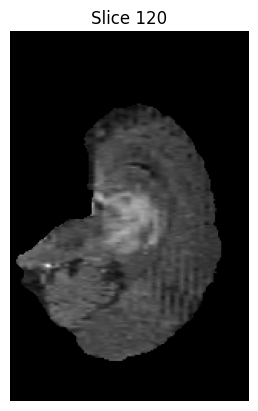

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your npy file (example: flair volume)
npy_path = "../data/BraTS_2020_Train/flair/BraTS20_Training_flair_001.npy"

# Load the MRI volume
volume = np.load(npy_path)

print("Volume shape:", volume.shape)   # (depth, height, width) or similar

# Show a single slice
slice_index = volume.shape[0] // 2  # middle slice
plt.imshow(volume[slice_index, :, :], cmap="gray")
plt.title(f"Slice {slice_index}")
plt.axis("off")
plt.show()


In [40]:
from ipywidgets import interact

def view_slice(idx):
    plt.imshow(volume[idx, :, :], cmap="gray")
    plt.title(f"Slice {idx}")
    plt.axis("off")
    plt.show()

interact(view_slice, idx=(0, volume.shape[0]-1))


interactive(children=(IntSlider(value=119, description='idx', max=239), Output()), _dom_classes=('widget-inter…

<function __main__.view_slice(idx)>